# Notebook showing a fast and efficient way to load Sentinel-2 L1C data into xarray

In [9]:
import glob
import os
import numpy as np

import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap

import GRSdriver
from GRSdriver import visual

opj = os.path.join

print(f'-GRSdriver: {GRSdriver.__version__}')


-GRSdriver: 1.0.5


Set the path of the images you want to load, here is a example for the former (v3) and current (v4) image formatting 

In [2]:
image ='/data/satellite/landsat/LC09_L1TP_196030_20221120_20230321_02_T1'
cams_file = '/data/cams/world/cams_forecast_2022-11.nc'

In [3]:
l1c = GRSdriver.LandsatDriver(image,band_idx=[1,2,4,6,9,10])

In [4]:
l1c.INFO

bandId             1      2    4            6      9      10
ESA               B02    B03  B04          B09    B08    B09
EOREADER         BLUE  GREEN  RED  SWIR_CIRRUS  TIR_1  TIR_2
Wavelength (nm)   490    560  665         1370  11000  12000
Band width (nm)    60     60   33           21    590   1010
Resolution (m)     30     30   30           30    100    100

In [5]:
l1c.load_mask()

In [6]:
l1c.load_product()

/home/harmel/anaconda3/envs/grstbx/lib/python3.9/site-packages/xarray/core/indexes.py:659: RuntimeWarning: '<' not supported between instances of 'SpectralBandNames' and 'SpectralBandNames', sort order is undefined for incomparable objects.
  new_pd_index = pd_indexes[0].append(pd_indexes[1:])


In [7]:
l1c.prod

<xarray.Dataset>
Dimensions:      (x: 7671, y: 7791, wl: 6, wl_hr: 2951)
Coordinates:
  * x            (x) float64 5.349e+05 5.349e+05 5.35e+05 ... 7.65e+05 7.65e+05
  * y            (y) float64 4.899e+06 4.899e+06 ... 4.666e+06 4.666e+06
    spatial_ref  int64 0
  * wl           (wl) object 490 560 665 1370 11000 12000
  * wl_hr        (wl_hr) float64 400.0 401.0 402.0 ... 1.35e+04 1.35e+04
    time         datetime64[ns] 2022-11-20T10:24:21
    band         int64 1
Data variables:
    bands        (wl, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    SRF          (wl, wl_hr) float64 ...
    wl_true      (wl) float64 482.3 560.9 654.3 1.374e+03 1.084e+04 1.203e+04
    sza          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    vza          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    raa          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    flags_l1     (y, x) uint32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
Attributes: (12/17)
    long_name:              BLUE GREEN RED SWIR_CIRRUS TIR_1 TIR_2
    constellation:          Landsat-9
    constellation_id:       L9
    product_path:           /data/satellite/landsat/LC09_L1TP_196030_20221120...
    product_name:           LC09_L1TP_196030_20221120_20230321_02_T1
    product_filename:       LC09_L1TP_196030_20221120_20230321_02_T1
    ...                     ...
    radiometry:             reflectance and brightness temperature
    cloud_cover:            0.2
    wl_to_process:          [ 443  490  560  590  665  865 1610 2190]
    satellite:              Landsat-9
    solar_irradiance:       NA
    solar_irradiance_unit:  W/m²/µm

Open CAMS data with lazy loading

In [75]:
cams =xr.open_dataset(cams_file)
cams

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, time: 240)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2022-11-01 ... 2022-11-30T21:00:00
Data variables: (12/22)
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    amaod550   (time, latitude, longitude) float32 ...
    bcaod550   (time, latitude, longitude) float32 ...
    ...         ...
    tcco       (time, latitude, longitude) float32 ...
    tc_ch4     (time, latitude, longitude) float32 ...
    tcno2      (time, latitude, longitude) float32 ...
    gtco3      (time, latitude, longitude) float32 ...
    tcwv       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-21 18:34:02 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Get data for the date of the image

In [76]:
date = l1c.prod.time.dt.strftime('%Y-%m-%d').values
date

array('2022-11-20', dtype=object)

In [77]:
cams = cams.sel(time=date)
cams

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, time: 8)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2022-11-20 ... 2022-11-20T21:00:00
Data variables: (12/22)
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    amaod550   (time, latitude, longitude) float32 ...
    bcaod550   (time, latitude, longitude) float32 ...
    ...         ...
    tcco       (time, latitude, longitude) float32 ...
    tc_ch4     (time, latitude, longitude) float32 ...
    tcno2      (time, latitude, longitude) float32 ...
    gtco3      (time, latitude, longitude) float32 ...
    tcwv       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-21 18:34:02 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [78]:
cams.rio.write_crs(4326,inplace=True)

<xarray.Dataset>
Dimensions:      (longitude: 900, latitude: 451, time: 8)
Coordinates:
  * longitude    (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude     (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time         (time) datetime64[ns] 2022-11-20 ... 2022-11-20T21:00:00
    spatial_ref  int64 0
Data variables: (12/22)
    v10          (time, latitude, longitude) float32 ...
    t2m          (time, latitude, longitude) float32 ...
    msl          (time, latitude, longitude) float32 ...
    sp           (time, latitude, longitude) float32 ...
    amaod550     (time, latitude, longitude) float32 ...
    bcaod550     (time, latitude, longitude) float32 ...
    ...           ...
    tcco         (time, latitude, longitude) float32 ...
    tc_ch4       (time, latitude, longitude) float32 ...
    tcno2        (time, latitude, longitude) float32 ...
    gtco3        (time, latitude, longitude) float32 ...
    tcwv         (time, latitude, longitude) float32 ...
    u10          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-21 18:34:02 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [79]:
epsg = cams.rio.crs.to_epsg()
str_epsg = str(epsg)
zone = str_epsg[-2:]
is_south = str_epsg[2] == 7
proj = ccrs.UTM(zone, is_south)

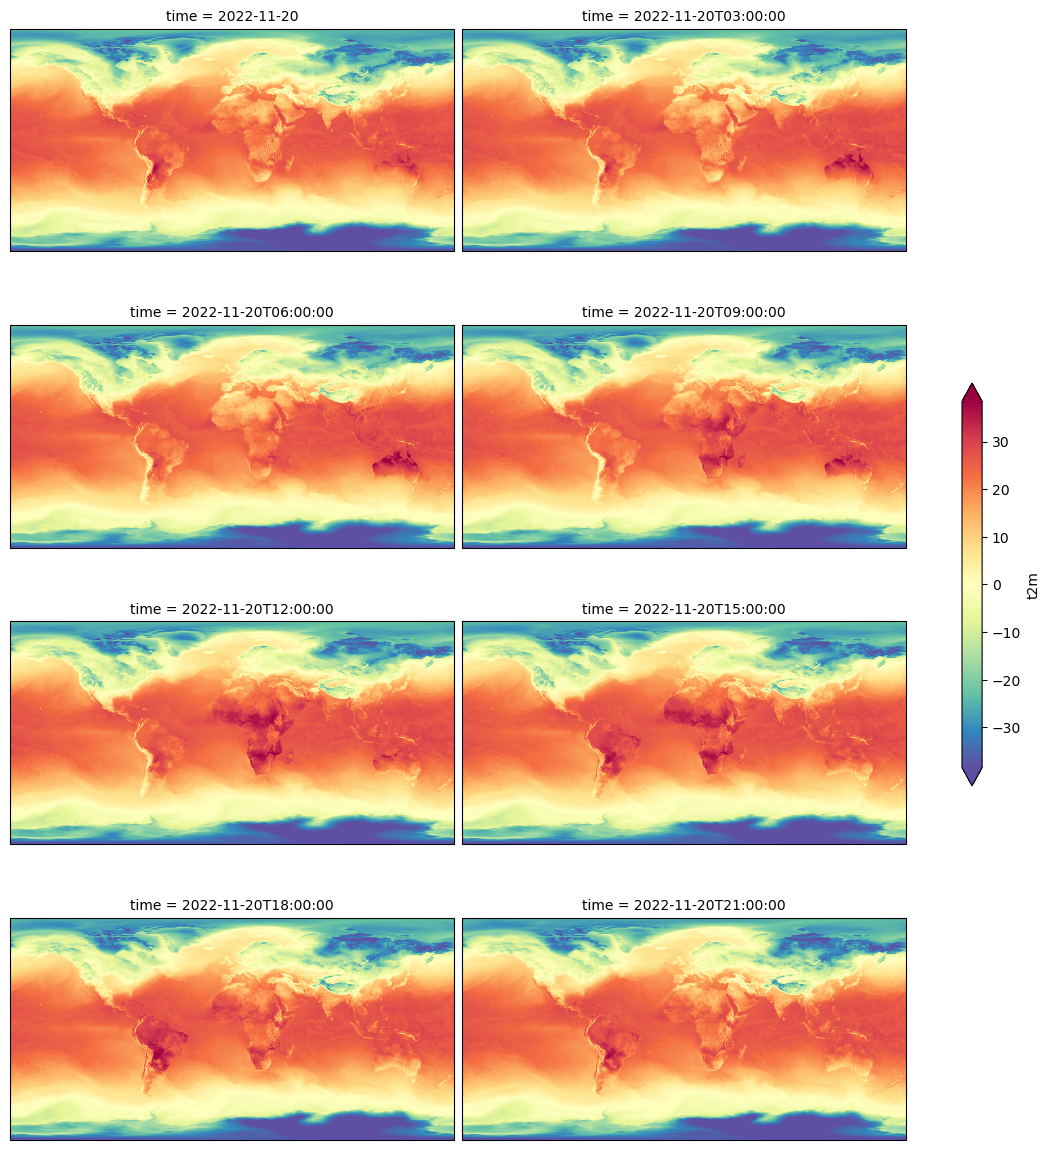

In [80]:

(cams.t2m-273.15).plot.imshow(col='time',col_wrap=2,cmap=plt.cm.Spectral_r,aspect=1.75,robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35}) #,vmin=-5,vmax=20)

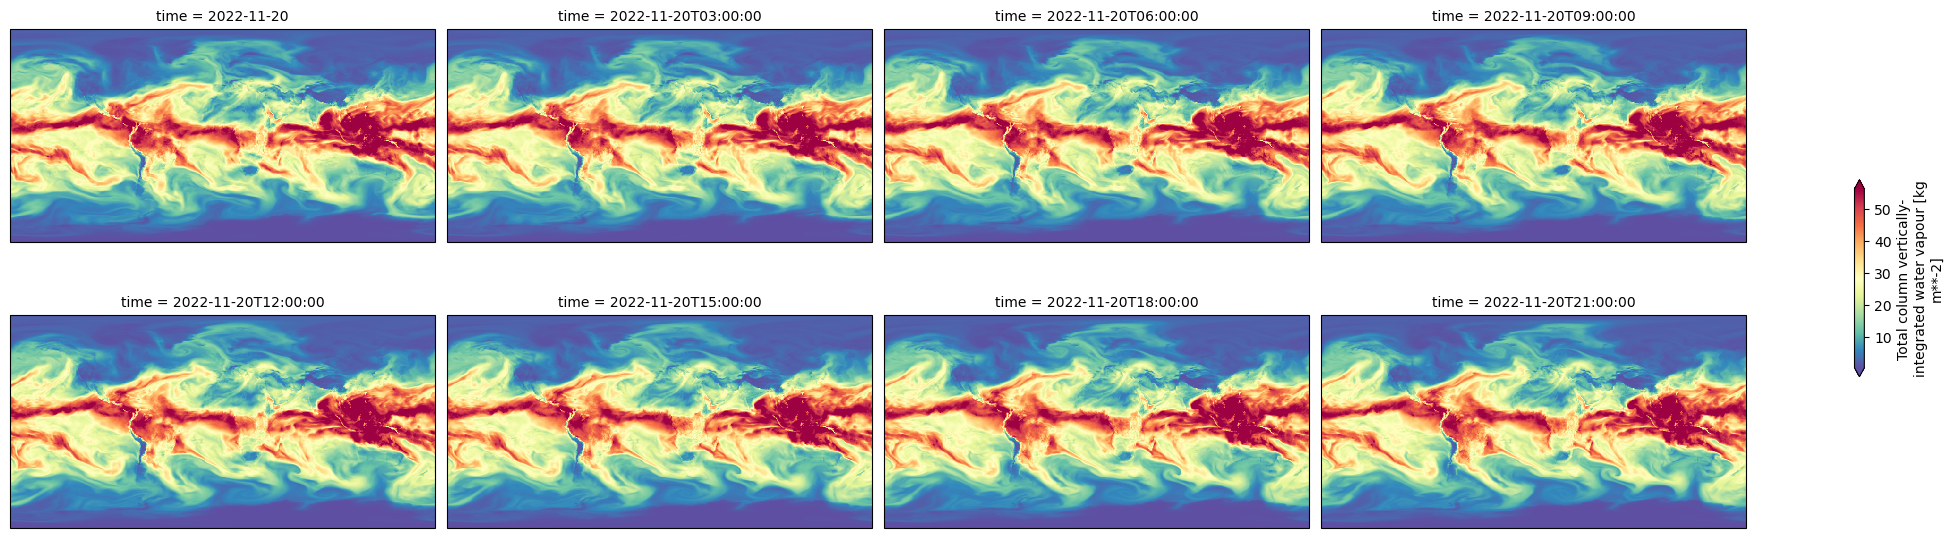

In [81]:
cams.tcwv.plot.imshow(col='time',col_wrap=4,cmap=plt.cm.Spectral_r,aspect=1.75,robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})

Now you can subset to the landsat image extent

In [82]:
cams.rio.bounds()

(-180.20000000339462, -90.2, 179.80000610691025, 90.2)

In [84]:
xmin, ymin, xmax, ymax = l1c.prod.rio.bounds()
lonmin, latmin, lonmax, latmax = l1c.prod.rio.transform_bounds(4326)

cams = cams.sel(latitude=slice(latmax + 1, latmin - 1))
# check if image is on Greenwich meridian and adapt longitude convention
if cams.longitude.min()>=0:
    if lonmin <= 0 and lonmax >= 0:

        cams = cams.assign_coords({"longitude": (((cams.longitude + 180) % 360) - 180)}).sortby('longitude')
    else:
        # set longitude between 0 and 360 deg
        lonmin, lonmax, = lonmin % 360, lonmax % 360

# slicing
cams = cams.sel(longitude=slice(lonmin - 1, lonmax + 1))
#.compute()
cams

<xarray.Dataset>
Dimensions:      (longitude: 12, latitude: 11, time: 8)
Coordinates:
  * longitude    (longitude) float32 2.8 3.2 3.6 4.0 4.4 ... 5.6 6.0 6.4 6.8 7.2
  * latitude     (latitude) float32 45.2 44.8 44.4 44.0 ... 42.4 42.0 41.6 41.2
  * time         (time) datetime64[ns] 2022-11-20 ... 2022-11-20T21:00:00
    spatial_ref  int64 0
Data variables: (12/22)
    v10          (time, latitude, longitude) float32 ...
    t2m          (time, latitude, longitude) float32 273.7 274.6 ... 290.0 290.1
    msl          (time, latitude, longitude) float32 ...
    sp           (time, latitude, longitude) float32 ...
    amaod550     (time, latitude, longitude) float32 ...
    bcaod550     (time, latitude, longitude) float32 ...
    ...           ...
    tcco         (time, latitude, longitude) float32 ...
    tc_ch4       (time, latitude, longitude) float32 ...
    tcno2        (time, latitude, longitude) float32 ...
    gtco3        (time, latitude, longitude) float32 ...
    tcwv         (time, latitude, longitude) float32 5.76 6.642 ... 17.78 17.32
    u10          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-21 18:34:02 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

if your subset is small, it might be useful to interpolate within the native raster

In [85]:
regrid_number=100
cams=cams.interp(latitude=np.linspace(cams.latitude.max(),cams.latitude.min(),regrid_number),
            longitude=np.linspace(cams.longitude.min(),cams.longitude.max(),regrid_number))
cams

<xarray.Dataset>
Dimensions:      (time: 8, latitude: 100, longitude: 100)
Coordinates:
  * time         (time) datetime64[ns] 2022-11-20 ... 2022-11-20T21:00:00
    spatial_ref  int64 0
  * latitude     (latitude) float64 45.2 45.16 45.12 45.08 ... 41.28 41.24 41.2
  * longitude    (longitude) float64 2.8 2.844 2.889 2.933 ... 7.111 7.156 7.2
Data variables: (12/22)
    v10          (time, latitude, longitude) float64 -1.326 -1.364 ... -9.15
    t2m          (time, latitude, longitude) float64 273.7 273.8 ... 290.0 290.1
    msl          (time, latitude, longitude) float64 1.019e+05 ... 1.015e+05
    sp           (time, latitude, longitude) float64 8.969e+04 ... 1.016e+05
    amaod550     (time, latitude, longitude) float64 0.001874 ... 0.001232
    bcaod550     (time, latitude, longitude) float64 0.0001906 ... 0.0005212
    ...           ...
    tcco         (time, latitude, longitude) float64 0.0006272 ... 0.000797
    tc_ch4       (time, latitude, longitude) float64 0.009108 ... 0.01041
    tcno2        (time, latitude, longitude) float64 3.513e-06 ... 3.325e-06
    gtco3        (time, latitude, longitude) float64 0.006799 ... 0.006113
    tcwv         (time, latitude, longitude) float64 5.76 5.858 ... 17.37 17.32
    u10          (time, latitude, longitude) float64 2.168 2.115 ... 11.31 11.23
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-21 18:34:02 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [92]:
cams=cams.rio.reproject(l1c.prod.rio.crs,nodata=np.nan)

In [93]:
cams

<xarray.Dataset>
Dimensions:      (x: 92, y: 112, time: 8)
Coordinates:
  * x            (x) float64 4.834e+05 4.875e+05 4.915e+05 ... 8.5e+05 8.541e+05
  * y            (y) float64 5.014e+06 5.01e+06 ... 4.566e+06 4.562e+06
  * time         (time) datetime64[ns] 2022-11-20 ... 2022-11-20T21:00:00
    spatial_ref  int64 0
Data variables: (12/22)
    v10          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    t2m          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    msl          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    sp           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    amaod550     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    bcaod550     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    ...           ...
    tcco         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    tc_ch4       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    tcno2        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    gtco3        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    tcwv         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    u10          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-21 18:34:02 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

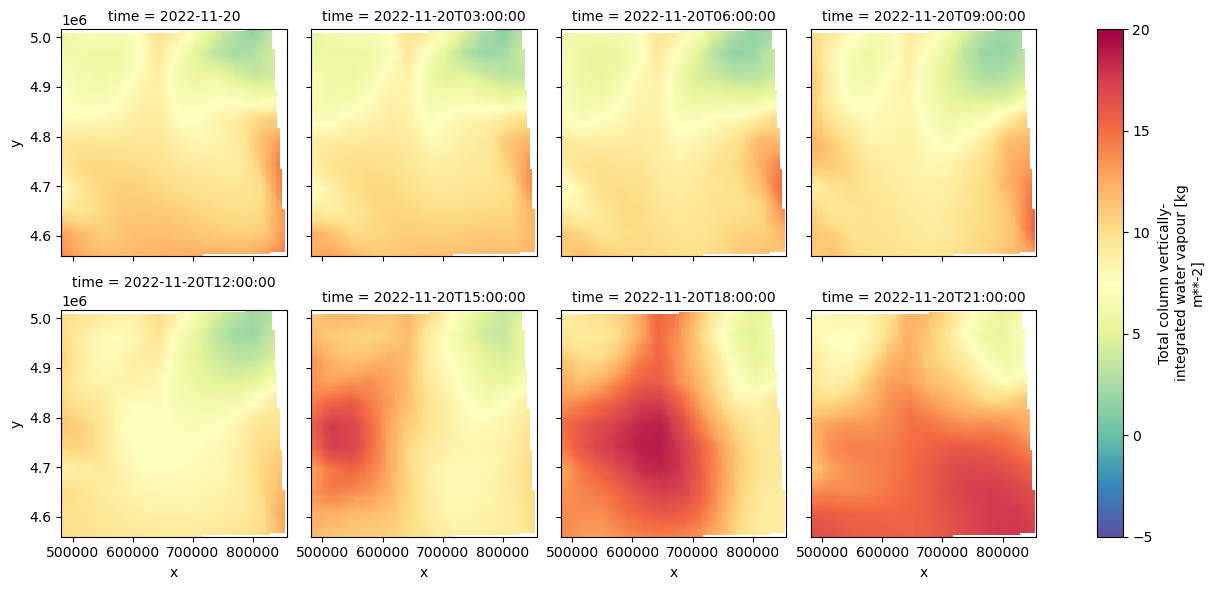

In [94]:
cams.tcwv.plot.imshow(col='time',col_wrap=4,cmap=plt.cm.Spectral_r,vmin=-5,vmax=20)

Final step is to clip the cams rasters to that of your satellite image

In [109]:
#
#xmin, ymin, xmax, ymax = l1c.prod.rio.bounds()
#cams.rio.clip_box(xmin, ymin, xmax, ymax)
#
# or simply:
cams = cams.rio.clip_box(*l1c.prod.rio.bounds())
cams

<xarray.Dataset>
Dimensions:      (x: 57, y: 59, time: 8)
Coordinates:
  * x            (x) float64 5.363e+05 5.404e+05 ... 7.604e+05 7.644e+05
  * y            (y) float64 4.9e+06 4.896e+06 4.892e+06 ... 4.668e+06 4.664e+06
  * time         (time) datetime64[ns] 2022-11-20 ... 2022-11-20T21:00:00
    spatial_ref  int64 0
Data variables: (12/22)
    v10          (time, y, x) float64 -2.82 -2.834 -2.847 ... -6.651 -6.638
    t2m          (time, y, x) float64 274.8 274.9 275.0 ... 289.3 289.3 289.3
    msl          (time, y, x) float64 1.017e+05 1.017e+05 ... 1.015e+05
    sp           (time, y, x) float64 9.188e+04 9.189e+04 ... 1.015e+05
    amaod550     (time, y, x) float64 0.001716 0.001616 ... 0.0008582 0.0008759
    bcaod550     (time, y, x) float64 0.0002519 0.0002548 ... 0.0007793
    ...           ...
    tcco         (time, y, x) float64 0.0006389 0.0006385 ... 0.0008381
    tc_ch4       (time, y, x) float64 0.009351 0.009352 ... 0.01041 0.01041
    tcno2        (time, y, x) float64 3.917e-06 3.922e-06 ... 3.905e-06 3.89e-06
    gtco3        (time, y, x) float64 0.00681 0.006813 ... 0.006087 0.006092
    tcwv         (time, y, x) float64 6.306 6.267 6.229 ... 17.31 17.31 17.31
    u10          (time, y, x) float64 2.903 2.866 2.83 ... 13.03 13.03 13.03
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-21 18:34:02 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

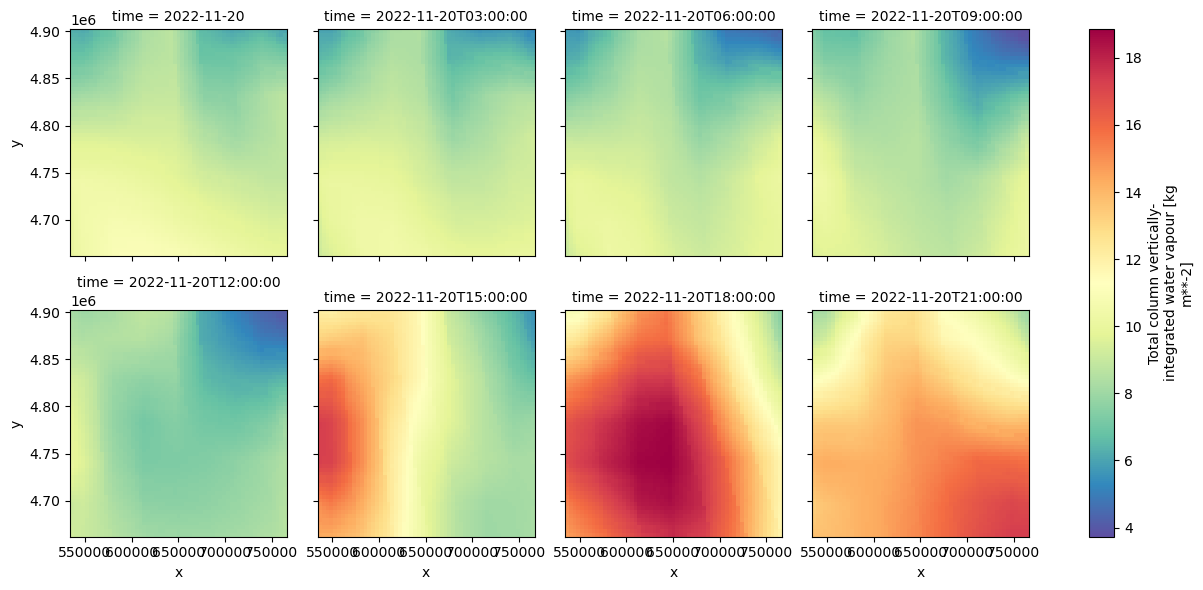

In [111]:
cams.tcwv.plot.imshow(col='time',col_wrap=4,cmap=plt.cm.Spectral_r)

### Plotting examples:

Select the closest date

In [122]:
cams_ = cams.sel(time=l1c.prod.time,method='nearest')

In [123]:
wind = np.sqrt(cams_['v10']**2+cams_['u10']**2)

In [124]:
import cartopy.crs as ccrs

epsg = l1c.extent.crs.to_epsg()
str_epsg = str(epsg)
zone = str_epsg[-2:]
is_south = str_epsg[2] == 7
proj = ccrs.UTM(zone, is_south)

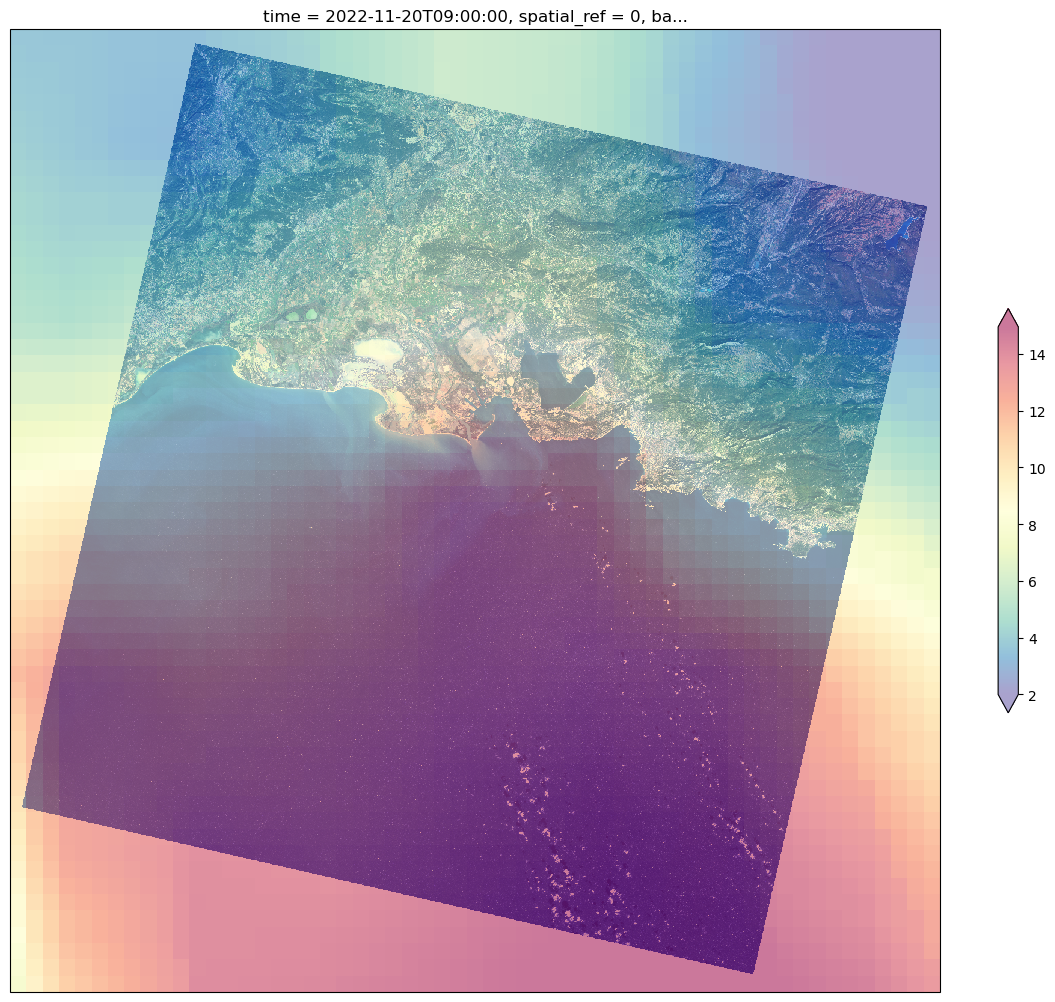

In [126]:
plt.figure(figsize=(15,15))

l1c.prod.bands.sel(wl=[665,560,490])[:,::5,::5].plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj))
wind.plot.imshow( cmap=plt.cm.Spectral_r,robust=True,alpha=0.53,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})


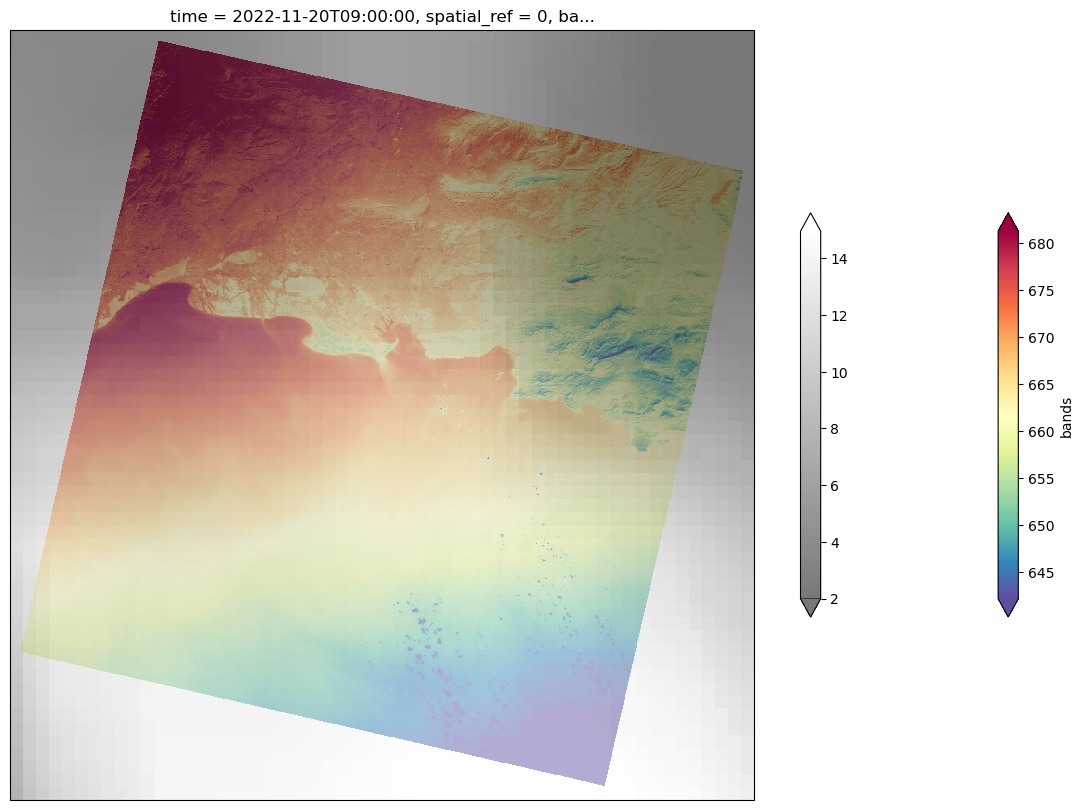

In [127]:
plt.figure(figsize=(15,15))

l1c.prod.bands.isel(wl=-1)[::5,::5].plot.imshow(cmap=plt.cm.Spectral_r,robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})
wind.plot.imshow( cmap=plt.cm.gray,robust=True,alpha=0.53,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})

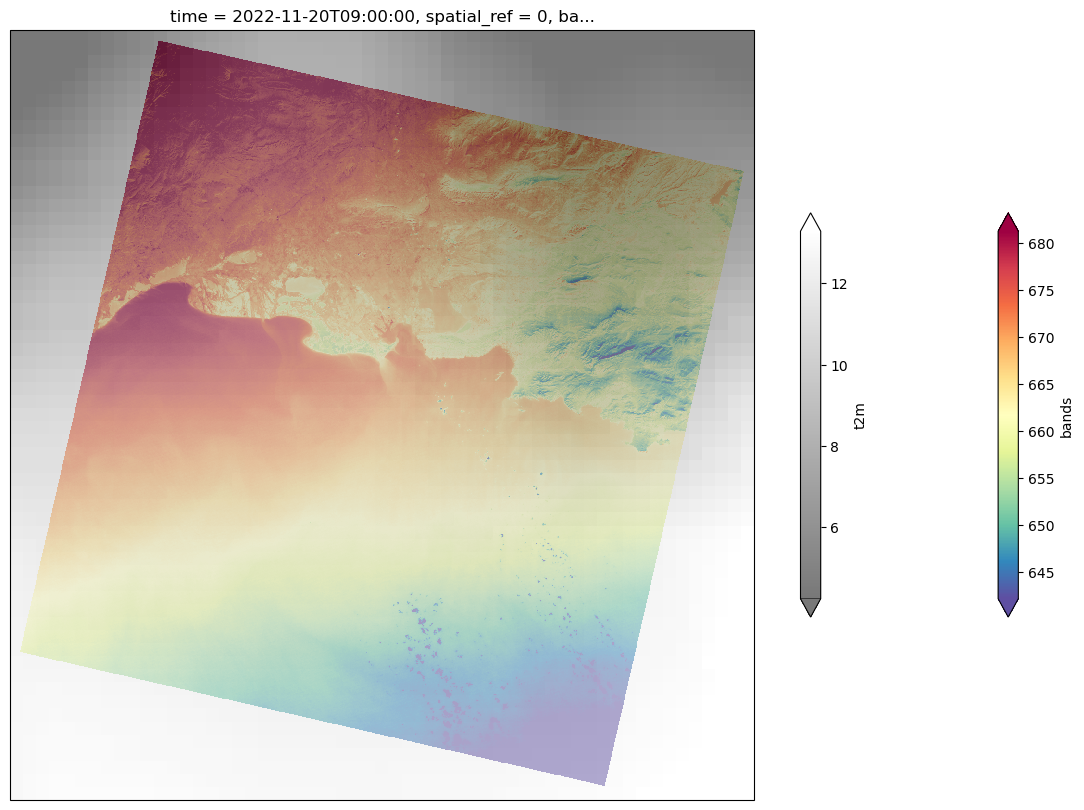

In [130]:
plt.figure(figsize=(15,15))

l1c.prod.bands.isel(wl=-1)[::5,::5].plot.imshow(cmap=plt.cm.Spectral_r,robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})
(cams_.t2m-273.15).plot.imshow( cmap=plt.cm.gray,robust=True,alpha=0.53,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})

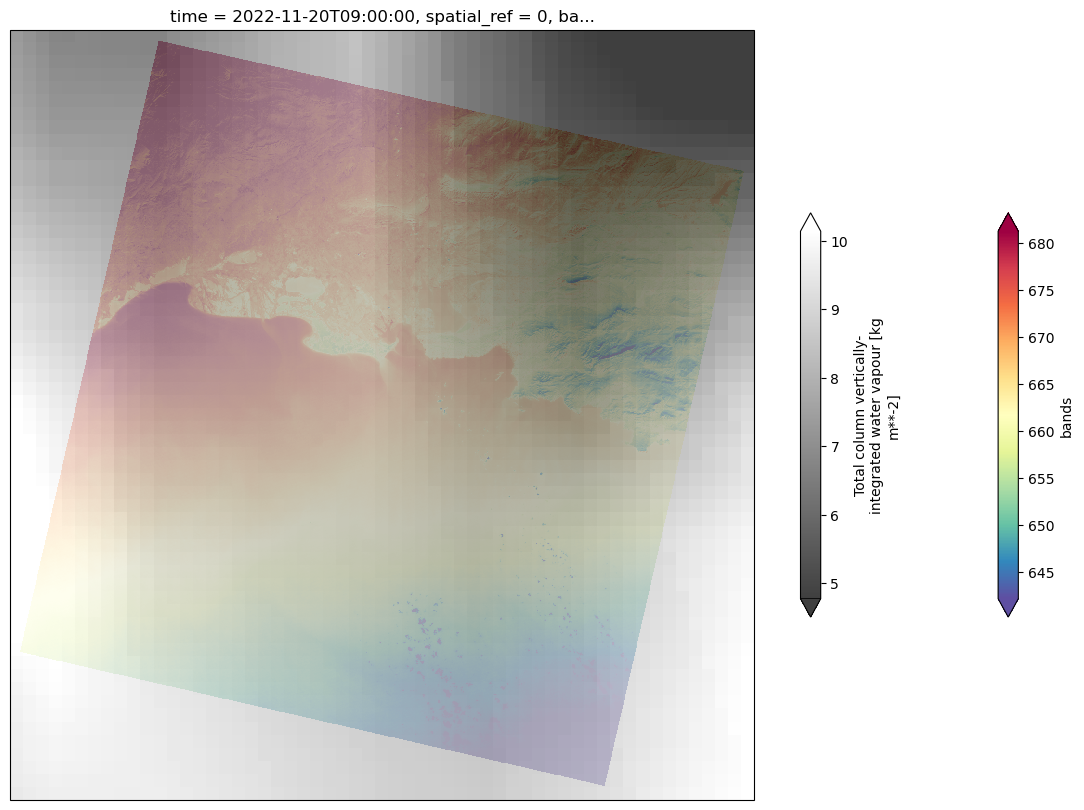

In [132]:
plt.figure(figsize=(15,15))

l1c.prod.bands.isel(wl=-1)[::5,::5].plot.imshow(cmap=plt.cm.Spectral_r,robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})
cams_.tcwv.plot.imshow( cmap=plt.cm.gray,robust=True,alpha=0.753,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})

In [87]:
h = visual.ViewSpectral(l1c.prod.bands[:,::5,::5],reproject=True)#.assign_coords(time=l1c.datetime).expand_dims('time')

In [88]:

h.visu()

Column
    [0] WidgetBox
        [0] Markdown(str)
        [1] Column
            [0] Row
                [0] Markdown(str)
                [1] RadioButtonGroup(options=[0, 1, 2, 3, 4, 5], value=0)
            [1] Row
                [0] Row
                    [0] Markdown(str)
                    [1] DatePicker(enabled_dates=[datetime.date(2022, ...], start=datetime.date(2022, ..., value=datetime.date(2022, ...)
                [1] Row
                    [0] Markdown(str)
                    [1] Select(options=['CartoDark', ...], value='CartoDark')
            [2] Row
                [0] Row
                    [0] Markdown(str)
                    [1] EditableRangeSlider(name='Range Slider', step=0.001, value=(0, 0.5), width=300)
                [1] Row
                    [0] Markdown(str)
                    [1] FloatSlider(name='Opacity', step=0.05, value=0.95)
                [2] Row
                    [0] Markdown(str)
                    [1] Select(options=['CET_D13', 'bky', ...], value='CET_D13')
        [2] HoloViews(DynamicMap, height=800, sizing_mode='fixed', width=1200)